In [1]:
adfile_path = r"C:\Users\21lyb\Downloads\PBMC_simulated_cnas_041025.h5ad"

In [2]:
import numpy as np
import pandas as pd
import scanpy as sc
import infercnvpy as cnv
import matplotlib.pyplot as plt
from biomart import BiomartServer
from io import StringIO
import anndata as ad
import warnings

warnings.simplefilter("ignore")

sc.settings.set_figure_params(figsize=(5, 5))

sc.logging.print_header()

c:\Users\21lyb\Documents\CSCB-2025-Final\.conda\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


numpy	1.26.4
pandas	2.2.3
scanpy	1.11.1
infercnvpy	0.6.0
matplotlib	3.10.0
biomart	0.9.2
anndata	0.11.4
----	----
urllib3	2.4.0
traitlets	5.14.3
PyYAML	6.0.2
stack-data	0.2.0
typing_extensions	4.13.2
charset-normalizer	3.4.1
legacy-api-wrap	1.4.1
certifi	2025.4.26 (2025.04.26)
idna	3.10
jupyter_client	8.6.3
parso	0.8.4
pycairo	1.28.0
kiwisolver	1.4.8
joblib	1.4.2
comm	0.2.1
matplotlib-inline	0.1.6
pyreadr	0.5.3
ipython	9.1.0
requests	2.32.3
setuptools	75.8.0
psutil	5.9.0
pillow	11.2.1 (9.4.0)
texttable	1.7.0
tqdm	4.67.1
packaging	24.2
asttokens	3.0.0
decorator	5.1.1
pywin32	308
executing	0.8.3
tornado	6.4.2
cffi	1.17.1
wcwidth	0.2.5
pure-eval	0.2.2
natsort	8.4.0
numba	0.61.2
prompt-toolkit	3.0.43
ipykernel	6.29.5
platformdirs	4.3.7
pyparsing	3.2.0
jedi	0.19.2
session-info2	0.1.2
scikit-learn	1.5.2
Pygments	2.19.1
threadpoolctl	3.6.0
Pillow	11.2.1 (9.4.0)
pyzmq	26.2.0
Brotli	1.0.9
colorama	0.4.6
jupyter_core	5.7.2
cycler	0.11.0 (0.12.1)
llvmlite	0.44.0
python-dateutil	2.9.0.post0
six	1.17.0
h5py	3.9.0
defusedxml	0.7.1
pytz	2025.2
debugpy	1.8.11
scipy	1.15.2
leidenalg	0.10.2
igraph	0.11.8
----	----
Python	3.11.6 | packaged by conda-forge | (main, Oct  3 2023, 10:29:11) [MSC v.1935 64 bit (AMD64)]
OS	Windows-10-10.0.26100-SP0
CPU	12 logical CPU cores, Intel64 Family 6 Model 165 Stepping 2, GenuineIntel
GPU	ID: 0, NVIDIA GeForce GTX 1650 Ti, Driver: 560.70, Memory: 4096 MiB
Updated	2025-05-02 18:45

In [3]:
# Functions
def qc(adata,
    mt_threshold_pct=20,
    min_genes=200,
    max_counts=50000,
    min_cells=3):

    adata1 = adata.copy()

    # Find MT genes
    adata1.var['mt'] = adata1.var_names.str.startswith('MT-')
    sc.pp.calculate_qc_metrics(adata1, qc_vars=['mt'],
                            percent_top=None,
                            log1p=False,
                            inplace=True)

    # Filter out cells based on MT genes
    adClean = adata1[adata1.obs['pct_counts_mt']<mt_threshold_pct,:].copy()

    # Filter out cells based on number of genes expressed
    sc.pp.filter_cells(adClean, min_genes=min_genes)

    # Filter out cells based on total counts
    sc.pp.filter_cells(adClean, max_counts=max_counts)

    # Filter out genes expressed in few cells
    sc.pp.filter_genes(adClean, min_cells=min_cells)

    return adClean

def preprocess(adata,
               min_mean=0.0125,
               max_mean=6,
               min_disp=0.25):
    
    adNorm = adata.copy()

    # Normalize and log transform
    adata.layers['counts'] = adata.X.copy()
    sc.pp.normalize_total(adata, target_sum=1e4)
    sc.pp.log1p(adata)

    # Detect highly variable genes
    sc.pp.highly_variable_genes(adata, min_mean=min_mean, max_mean=max_mean, min_disp=min_disp)

    # PCA
    sc.tl.pca(adata, use_highly_variable=True)
    sc.pl.pca_variance_ratio(adata,50)

    return adNorm

def KNN(adata, n_neighbors=20, n_pcs=10, annotation="cell_type"):
    sc.pp.neighbors(adata,n_neighbors=n_neighbors,n_pcs=n_pcs)
    sc.tl.umap(adata)
    sc.pl.umap(adata, color=annotation)

def downsample(adata,n_cells):
    if adata.n_obs <= n_cells:
        return adata
    else:
        return adata[np.random.choice(adata.obs_names, n_cells, replace=False), :].copy()

def fetch_positions(adata):
    # Connect to Ensembl Biomart server
    server = BiomartServer("http://grch37.ensembl.org/biomart")
    dataset = server.datasets['hsapiens_gene_ensembl']

    # Query gene names for only missing gene positions
    no_positions = adata[:, adata.var[['start', 'end']].isna().any(axis=1)]
    with_positions = adata[:, ~adata.var[['start', 'end']].isna().any(axis=1)]
    response = dataset.search({
        'filters':{'ensembl_gene_id':list(no_positions.var['gene_ids'])},
        'attributes':['ensembl_gene_id','chromosome_name','start_position','end_position','strand']
    })

    # Convert response to DataFrame and merge with adata.var if response is successful
    if response.status_code == 200:
        print("Request successful!")
        gene_annotations_df = pd.read_csv(StringIO(response.text),sep='\t',header=None)
        gene_annotations_df.columns = ['gene_ids','chromosome','start','end','strand']
    else:
        print(f"Request failed with status code: {response.status_code}")
        print(response.text)

    # Isolate fetched genes from BioMart in no_positions adata
    fetched_positions = no_positions[:, no_positions.var['gene_ids'].isin(gene_annotations_df['gene_ids'])].copy()

    # Sort fetched genes based on ensembl gene IDs
    fetched_positions = fetched_positions[:, fetched_positions.var['gene_ids'].argsort()].copy()

    # Add the fetched gene positions to the adata
    fetched_positions.var['chromosome'] = gene_annotations_df['chromosome'].values
    fetched_positions.var['start'] = gene_annotations_df['start'].values
    fetched_positions.var['end'] = gene_annotations_df['end'].values
    fetched_positions.var['strand'] = gene_annotations_df['strand'].values

    # Concatenate fetched genes with isolated genes already with positions
    adClean = ad.concat([with_positions, fetched_positions], axis=1)

    # Include obs into the cleaned adata
    adClean.obs = with_positions.obs.copy()

    return adClean

def standardize_chromosomes(adata):
    
    adata1 = adata.copy()

    # Add 'chr' prefix to chromosome names
    adata1.var['chromosome'] = 'chr' + adata1.var['chromosome'].astype(str)

    # Define standard chromosome names with 'chr' prefix
    standard_chromosomes = ['chr' + str(i) for i in range(1, 23)] + ['chrX', 'chrY', 'chrMT']

    # Filter adata to include only genes on standard chromosomes
    adata1 = adata1[:, adata1.var['chromosome'].isin(standard_chromosomes)].copy()

    return adata1

def infer_cnas(adata,reference_key='cell_type',reference_cat=[]):

    # Check if reference categories are provided, if not, use unique categories from the adata
    if len(reference_cat) == 0:
        reference_cat = list(adata.obs[reference_key].unique())

    # Run InferCNVpy
    cnv.tl.infercnv(adata,reference_key=reference_key,reference_cat=reference_cat,
                    exclude_chromosomes=None,chunksize=100,calculate_gene_values=True)

In [27]:
adata.layers['gene_values_cnv']

array([[ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       ...,
       [ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        , ..., -0.03457264,
         0.        ,  0.        ]])

In [4]:
adata = sc.read_h5ad(adfile_path)

In [5]:
# Run if needed:
# adata = qc(adata)
# adata = downsample(adata,n_cells=2000)

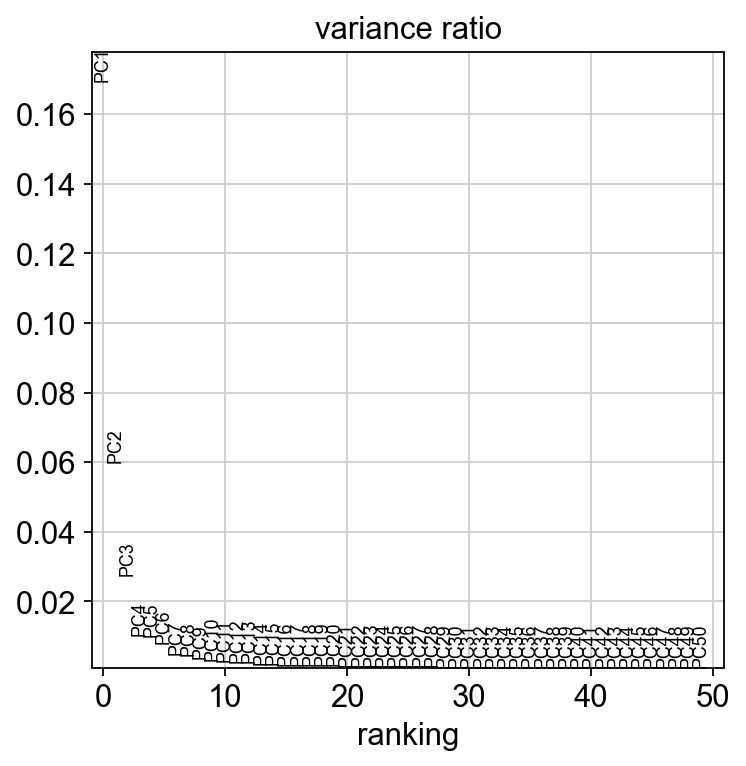

In [6]:
adata = preprocess(adata)

In [7]:
adata = fetch_positions(adata)

Request successful!


In [8]:
adata = standardize_chromosomes(adata)

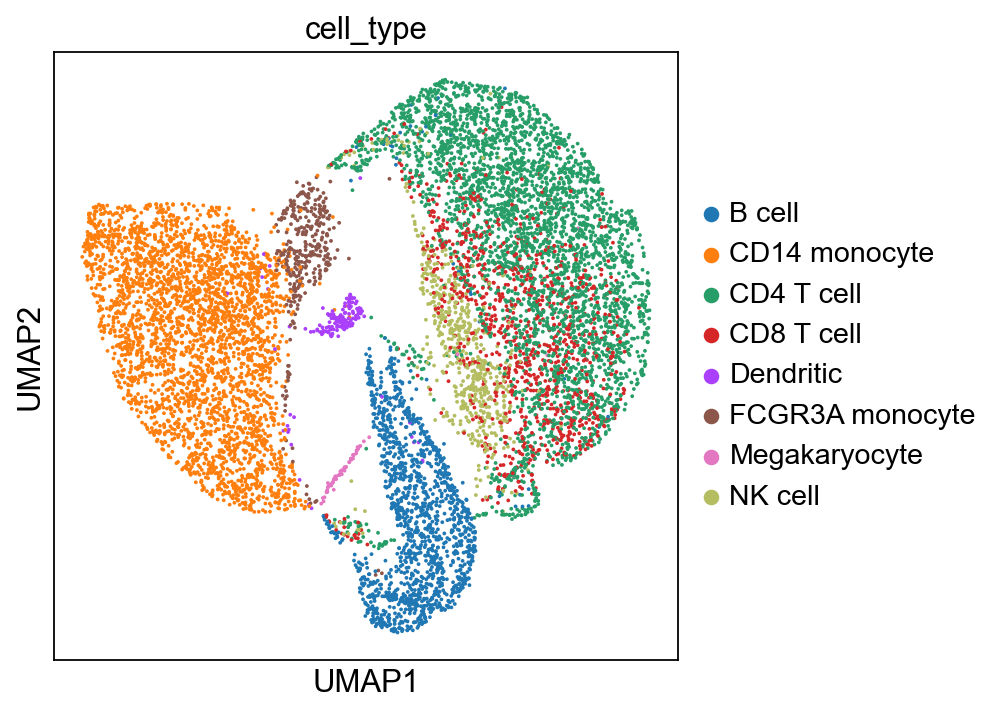

In [9]:
KNN(adata,n_pcs=10)

In [10]:
infer_cnas(adata,reference_key='cell_type')

100%|██████████| 104/104 [10:01<00:00,  5.78s/it]


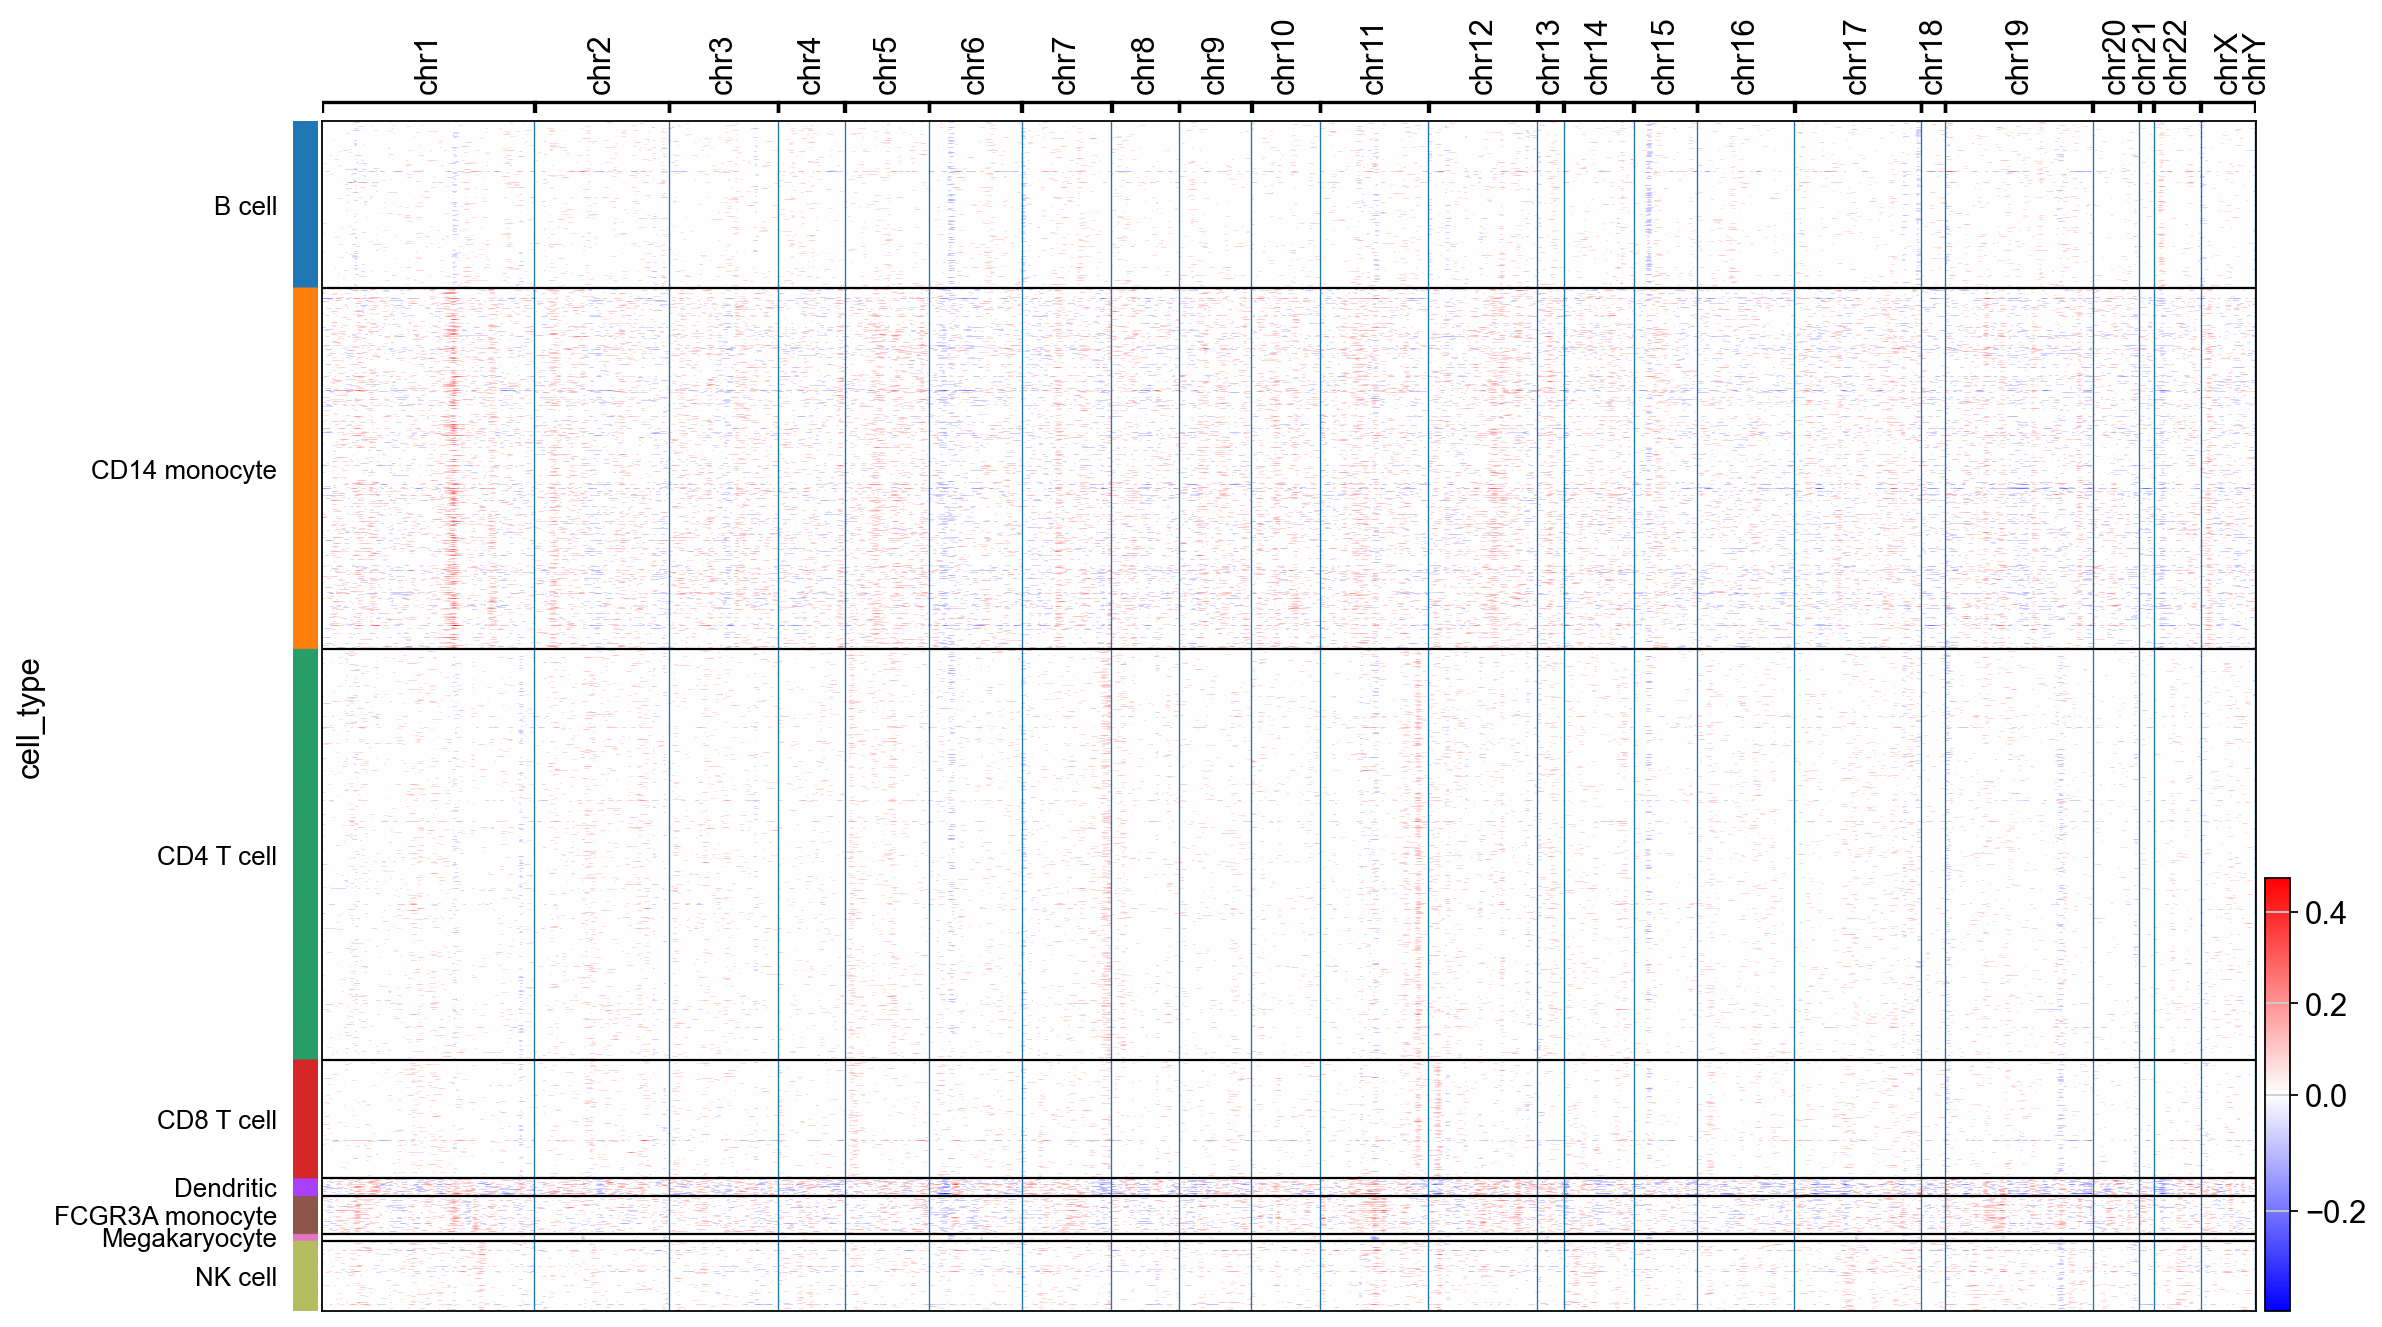

In [11]:
# Plot smoothed gene expression by cell type and chromosome
cnv.pl.chromosome_heatmap(adata, groupby="cell_type")

# You can observe that CD14 monocytes have significant decrease in expression of genes on chr6 and chr22
# (more blue/less red than genes on other chromosomes with enough genes for comparison)
# which is expected given the simulated chr6 and chr22 loss CNAs in CD14 monocytes

# The simulated CNA chrX gain is harder to see on the heatmap
# But if you zoom in you can see not many genes in blue
# which may indicate higher expression of genes on chrX

In [12]:
cnv.tl.pca(adata)
cnv.pp.neighbors(adata)
cnv.tl.leiden(adata)

categories: 0, 1, 2, etc.
var_group_labels: chr1, chr2, chr3, etc.


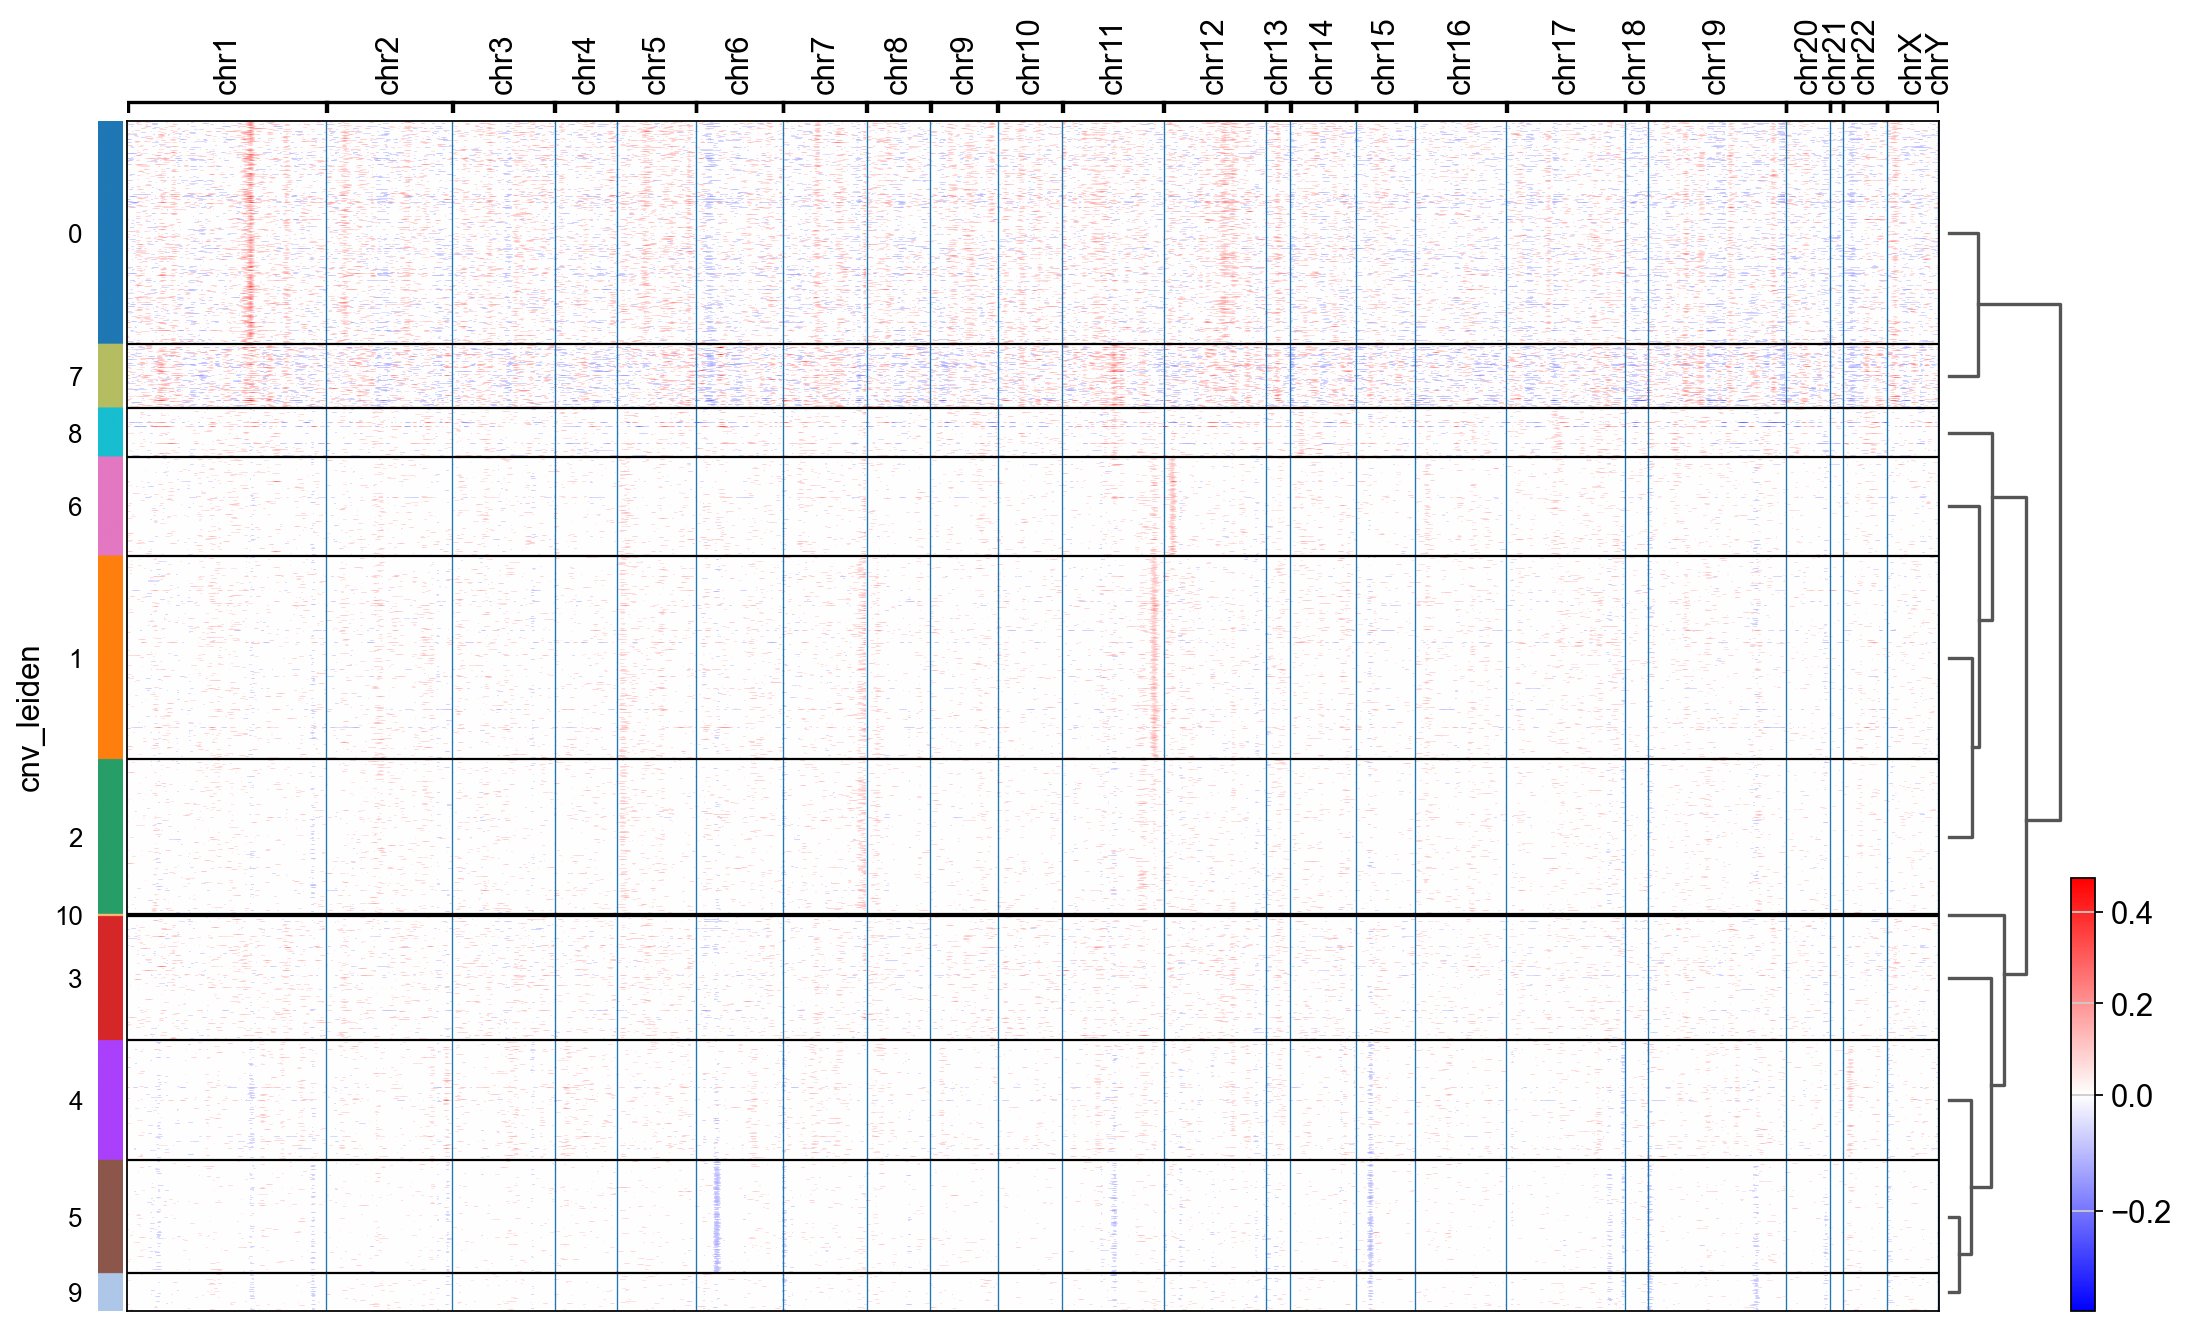

In [13]:
cnv.pl.chromosome_heatmap(adata, groupby="cnv_leiden", dendrogram=True)

In [14]:
cnv.tl.umap(adata)
cnv.tl.cnv_score(adata)

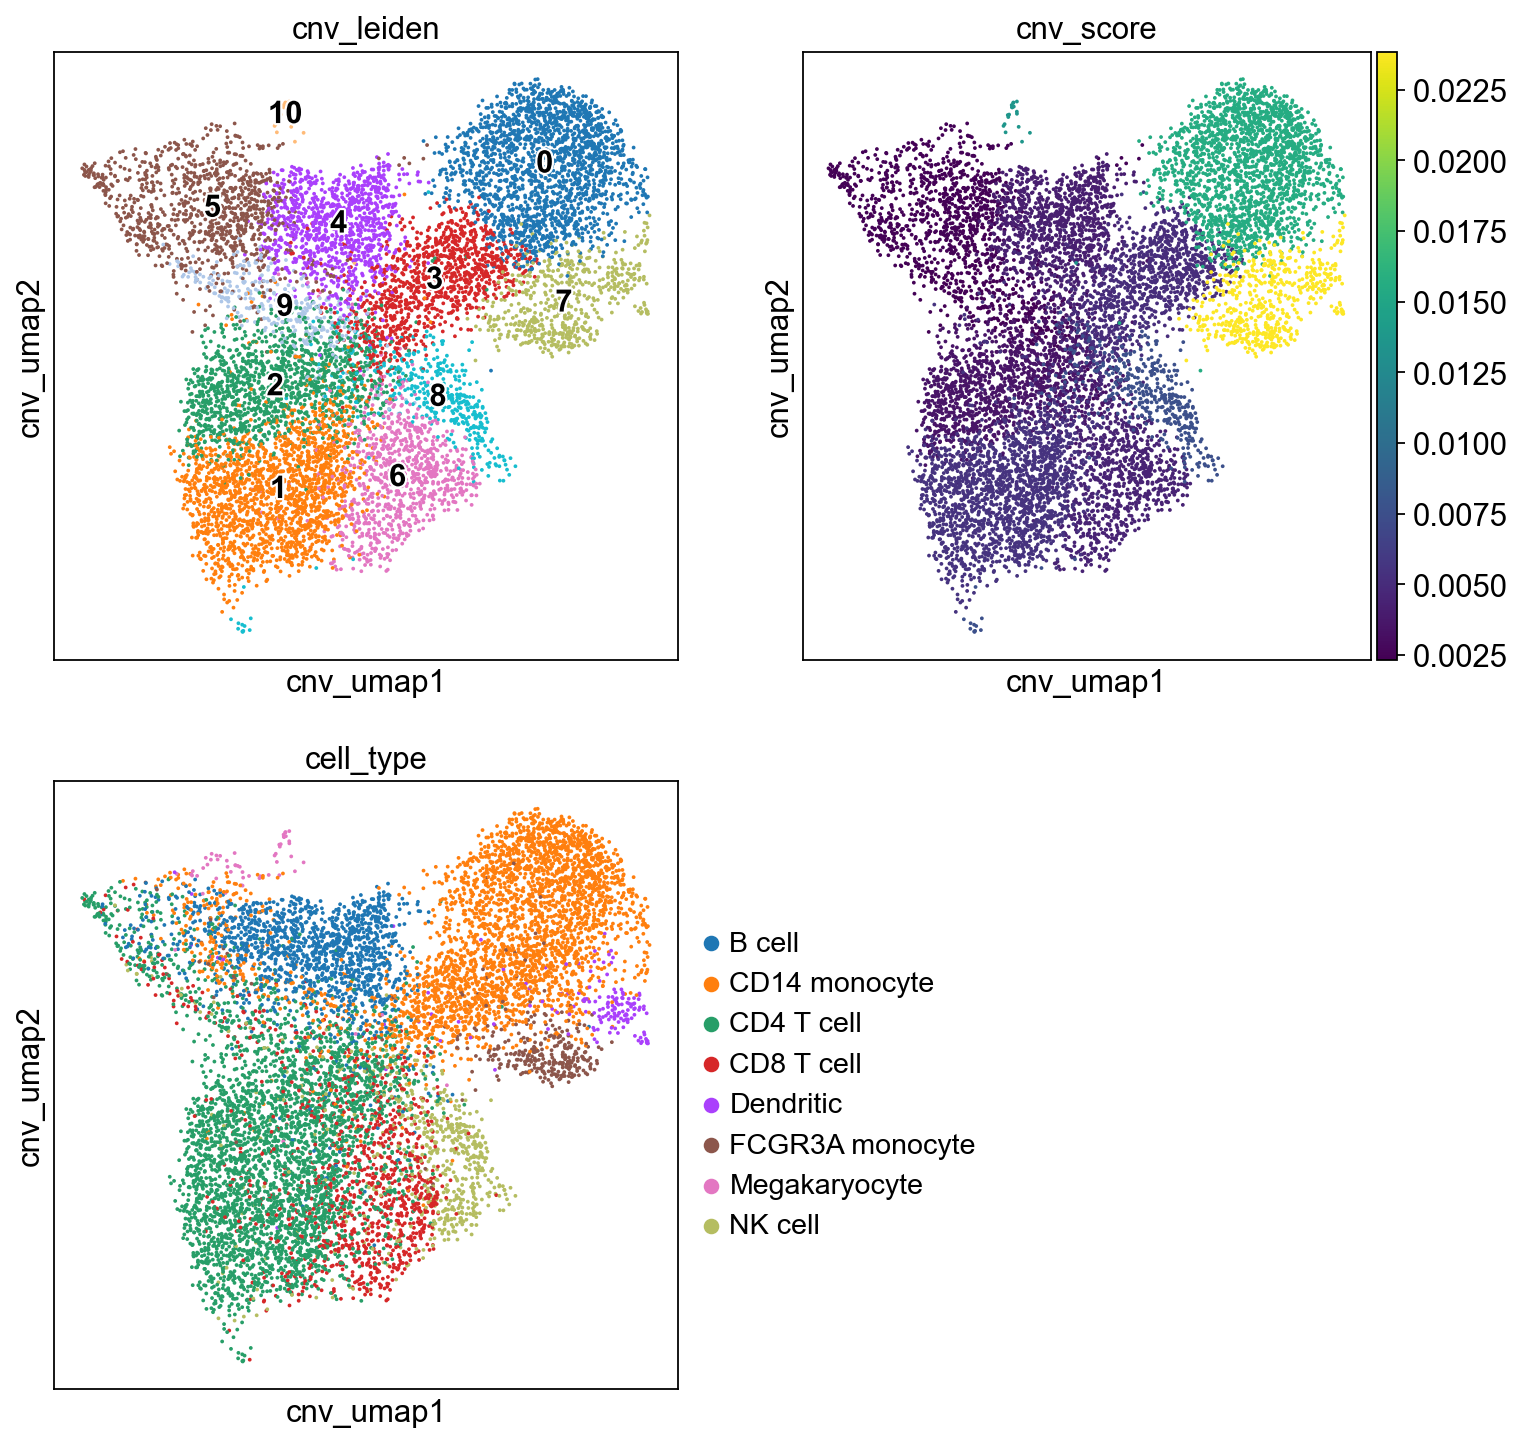

In [ ]:
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(11, 11))
ax4.axis("off")
cnv.pl.umap(
    adata,
    color="cnv_leiden",
    legend_loc="on data",
    legend_fontoutline=2,
    ax=ax1,
    show=False,
)
cnv.pl.umap(adata, color="cnv_score", ax=ax2, show=False)
cnv.pl.umap(adata, color="cell_type", ax=ax3)

# Possible CNV clusters: 0,1,3,7,8,10

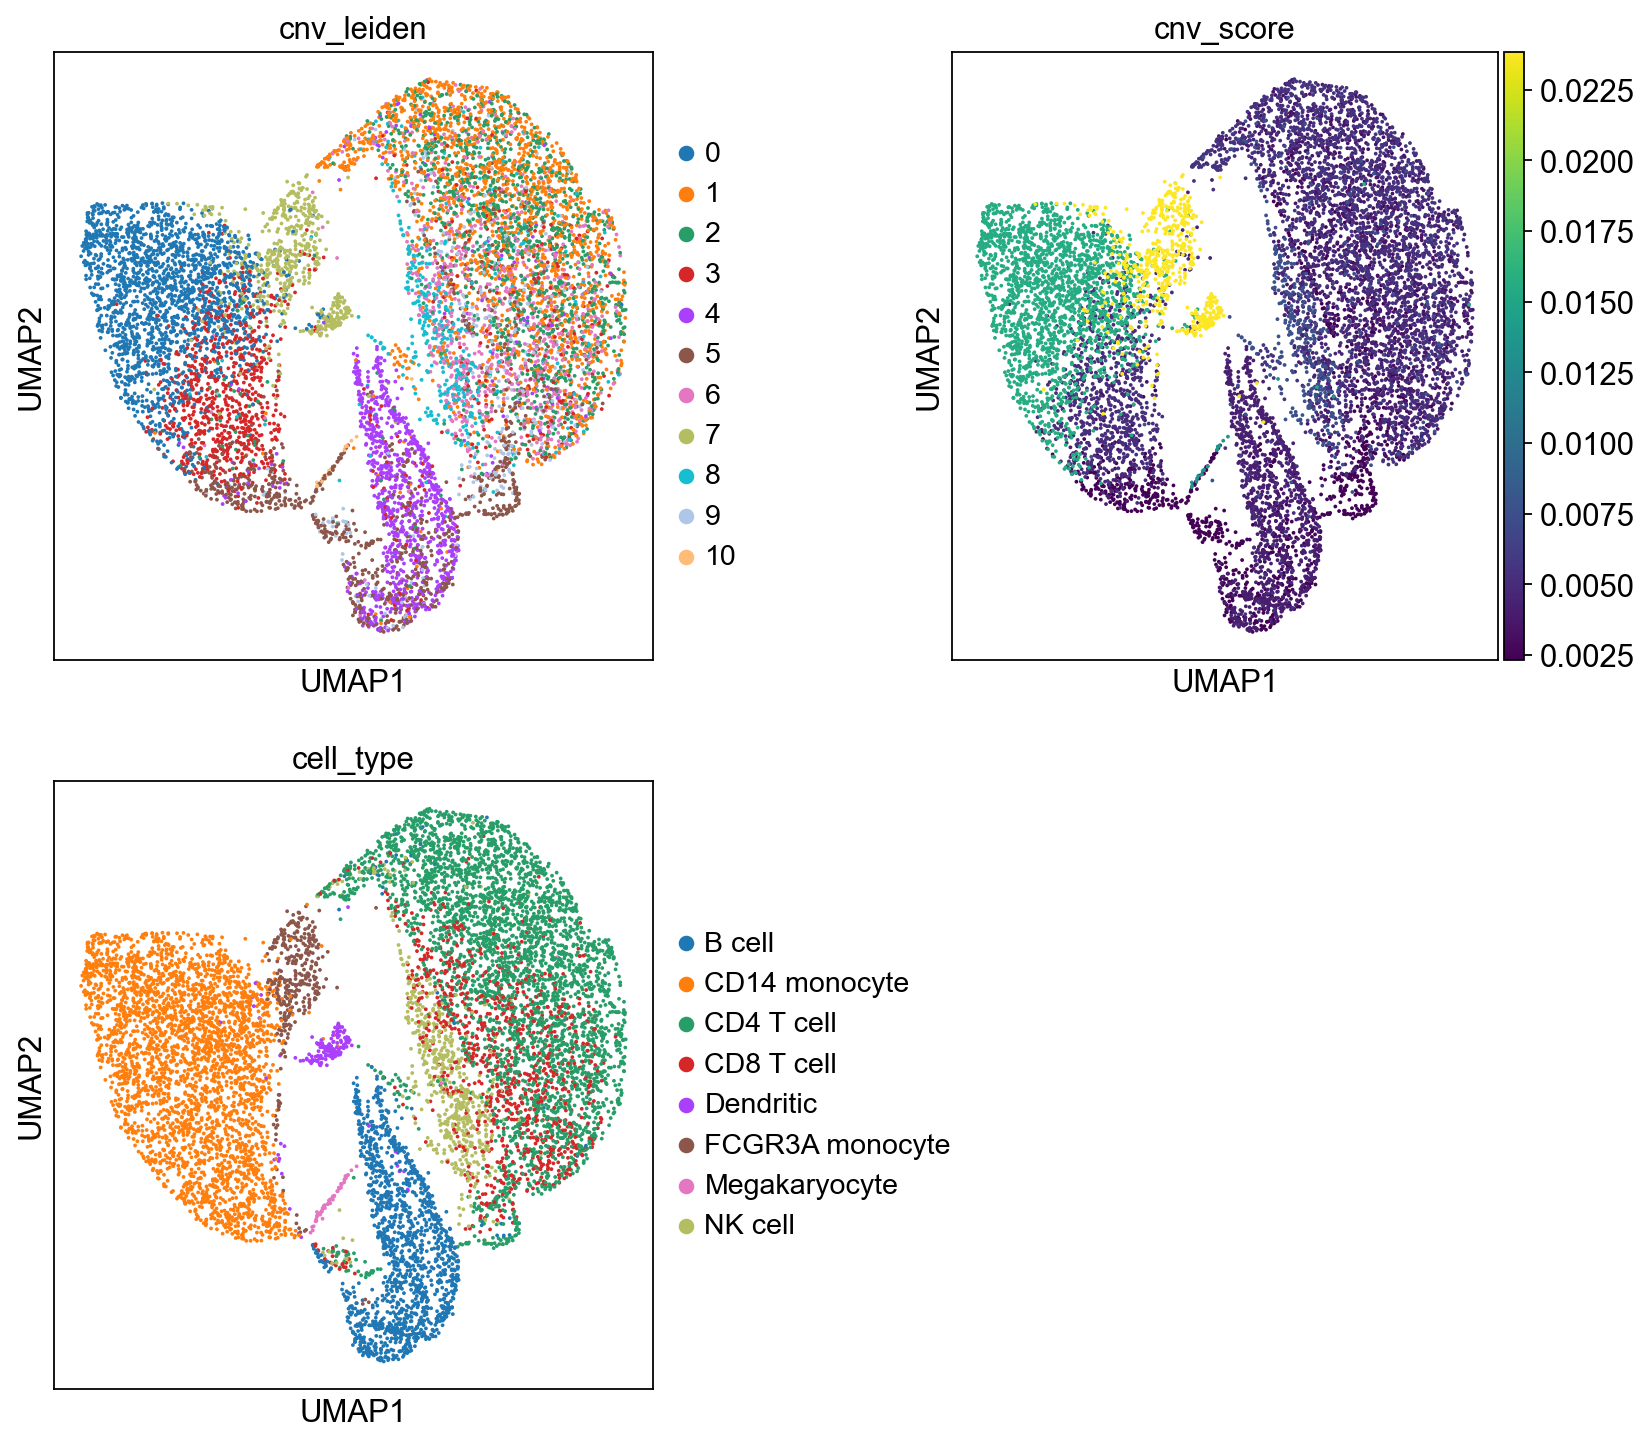

In [ ]:
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(12, 11), gridspec_kw={"wspace": 0.5})
ax4.axis("off")
sc.pl.umap(adata, color="cnv_leiden", ax=ax1, show=False)
sc.pl.umap(adata, color="cnv_score", ax=ax2, show=False)
sc.pl.umap(adata, color="cell_type", ax=ax3)

# Possible CNV clusters: 0,1,3,7,8,10
# Possible CNV cell types: CD14 monocyte, CD4 T cell, CD16 monocyte, NK cell
# Actual simulated CNVs:
# - CD14 monocytes: Chr6 loss, Chr22 loss
# - CD4 T cells: ChrX gain

In [ ]:
# Next steps:
# - Be able to set a threshold for CNV score to automatically select CNV cell
#    - A fraction of the maximum CNV score
# - Of all the cells in a CNV cluster, assign a selected chromosome where the CNV takes place
#    - Could be done by comparing average expression of all genes per chromosome
#      for the cells in that CNV cluster, and compare it to the average expression of all genes
#      per chromosome for all cells in the dataset
#    - Ensure there is enough genes in a chromosome to make a comparison
# - Find a way to get a genomic range (start, end) for the CNV
# - Format CNV column in adata.obs
# - If desired, replace current gene positions function with infercnvpy.io.genomic_position_from_biomart
# - Verify if infercnvpy PCA and neighbors functions should be ran after infercnvpy.tl.infercnv

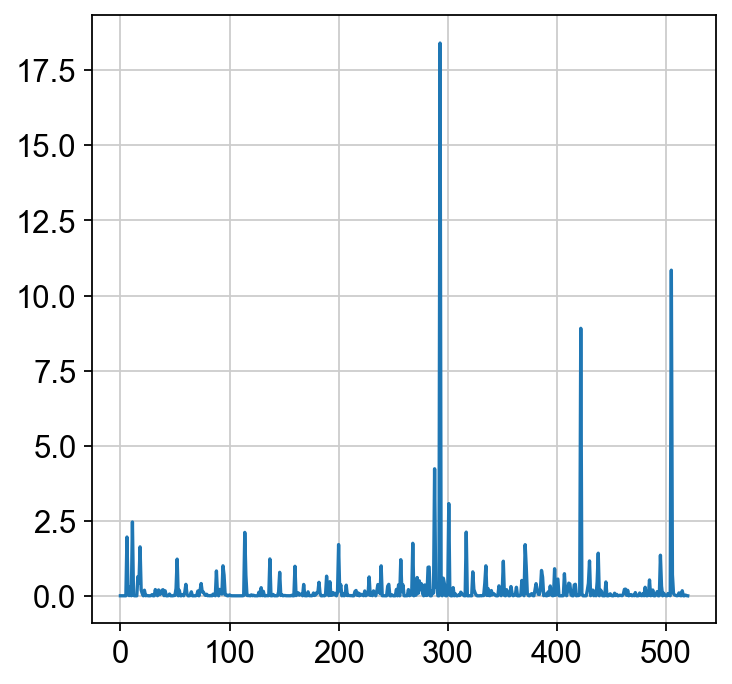

288
37570248.0
37582616.0


In [17]:
# Set a threshold for CNV score
threshold_fraction = 0.5
threshold_diff = 5*threshold_fraction
cnv_score_threshold = threshold_fraction * adata.obs['cnv_score'].max()

# Identify cells with CNVs over the threshold
adata.obs['has_cnv'] = adata.obs['cnv_score'] > cnv_score_threshold

chr = 'chr22'
cnv_column = 'has_cnv'

adata_temp = adata[:,adata.var['chromosome']==chr].copy()

# Sort temp adata genes by start position
adata_temp = adata_temp[:, adata_temp.var['start'].argsort()].copy()

# Isolate adata cells that have CNV
adata_cnv = adata_temp[adata_temp.obs[cnv_column],:].copy()
adata_normal = adata_temp[~adata_temp.obs[cnv_column],:].copy()

# Calculate average expression per chromosome for cells with CNV and for all cells
cnv_avg = np.array(adata_cnv.X.mean(axis=0))[0]
normal_avg = np.array(adata_normal.X.mean(axis=0))[0]

# Calculate the difference in expression
diff_exp = np.abs(cnv_avg - normal_avg)

# Identify regions with significant differences in expression
start_index, end_index = None, None

x = np.arange(len(diff_exp))

plt.plot(x,diff_exp)
plt.show()

print(np.argmax(diff_exp>threshold_diff))

print(adata_temp.var.iloc[np.argmax(diff_exp>threshold_diff)]['start'])
print(adata_temp.var.iloc[np.argmax(diff_exp>threshold_diff)]['end'])

In [18]:
mask = [False if len(x)==0 else True for x in adata.obs['simulated_cnvs']]
adata.obs['sim_cnv'] = mask
adata_sim = adata[adata.obs['sim_cnv'],:].copy()

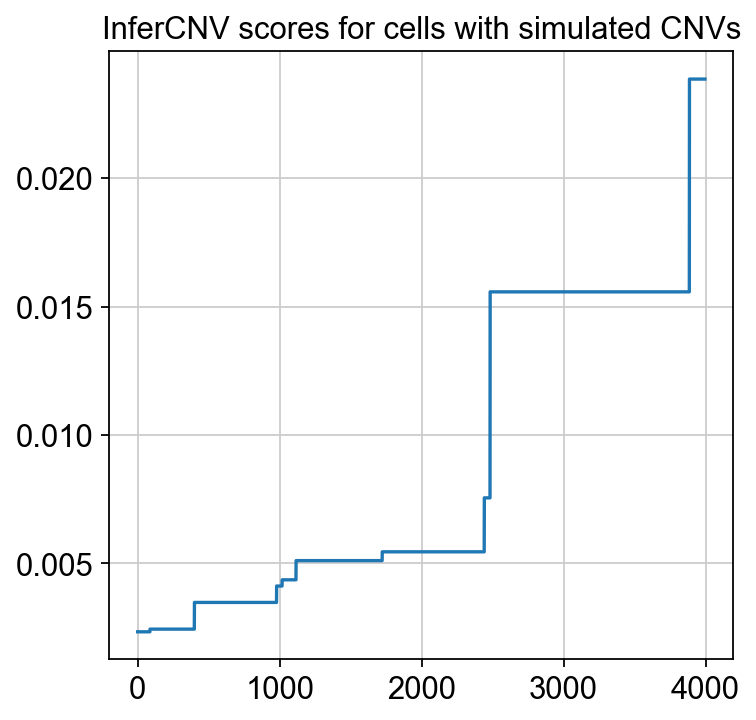

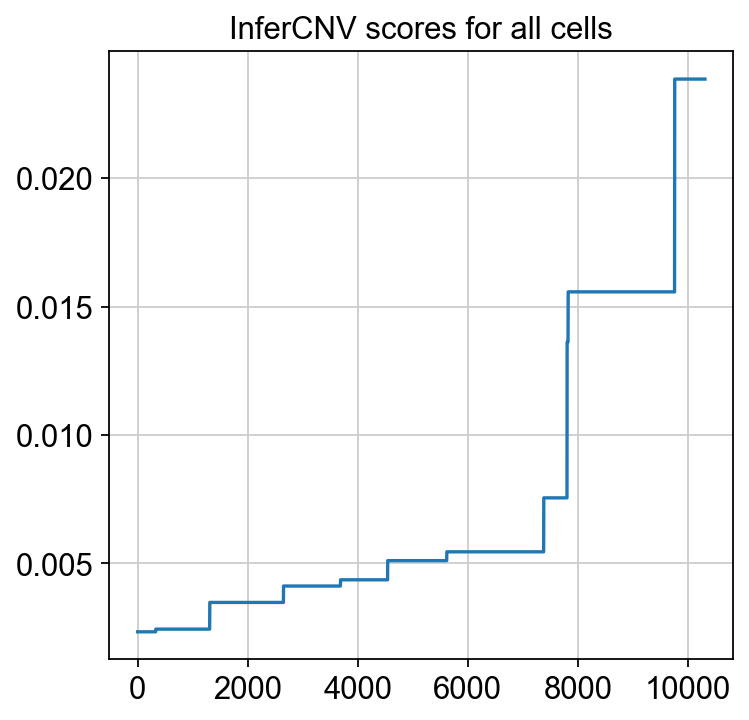

In [19]:
scores = list(adata_sim.obs['cnv_score'])
scores = sorted(scores)
x = np.arange(len(scores))
plt.plot(x,scores)
# plt.xlim(0,1000)
plt.title('InferCNV scores for cells with simulated CNVs')
plt.show()

scores = list(adata.obs['cnv_score'])
scores = sorted(scores)
x = np.arange(len(scores))
plt.plot(x,scores)
# plt.xlim(0,1000)
plt.title('InferCNV scores for all cells')
plt.show()

In [ ]:
# Assign chromosomes to cells with CNVs over the threshold
def assign_cnv_chromosome(adata,cnv_column='has_cnv',min_genes=1000,diff_threshold=0.2):
    
    standard_chromosomes = ['chr' + str(i) for i in range(1, 23)] + ['chrX', 'chrY', 'chrMT']

    for chr in standard_chromosomes:
        # Temp adata filtered to only genes on chromosome chr
        adata_temp = adata[:,adata.var['chromosome']==chr].copy()

        # Sort temp adata genes by start position
        adata_temp = adata_temp[:, adata_temp.var['start'].argsort()].copy()

        # Isolate adata cells that have CNV
        adata_cnv = adata_temp[adata_temp.obs[cnv_column],:].copy()

        # Calculate average expression per chromosome for cells with CNV and for all cells
        cnv_avg = np.array(adata_cnv.X.mean(axis=0))[0]
        all_avg = np.array(adata_temp.X.mean(axis=0))[0]

        # Calculate the difference in expression
        diff_exp = cnv_avg - all_avg

        # Identify regions with significant differences in expression
        start_index, end_index = None, None
        

    # For each cell that has a CNV
        # list of avg expression per chromosome
            # if # genes in chromosome is under a threshold, set expression to 0
        # list of differences: avg expression per chromosome in cell - in entire dataset
            # if # genes in chromosome is under a threshold, set expression to 0
        # find chromosome with the highest magnitude of difference
            # if diff>0, gain. if diff<0, loss
        # may set another threshold to determine if this difference is significant to be CNV
    
    return

In [19]:
# Simulated CNV information in dataset
# chr#:genomic range (CN #))
# CN 0: complete deletion
# CN 1: partial deletion
# CN 4: gain
np.unique(list(adata.obs['simulated_cnvs']))

array(['', '22:19807132-29743868 (CN 0)',
       '22:19807132-29743868 (CN 0), 6:25435484-35035259 (CN 1)',
       '6:25435484-35035259 (CN 1)', 'X:106533974-112956833 (CN 4)'],
      dtype='<U55')